In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json

# NLTK/SpaCy for preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    # Handle case where NLTK data isn't downloaded
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab') # Add download for punkt_tab
    STOPWORDS = set(stopwords.words('english'))

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Deep Learning Libraries (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

# --- Step 1: Data Loading (SYNTHETIC DATA FOR DEMO) ---

# The project requires 5-7 categories. We select 7 prominent and distinct categories.
TARGET_CATEGORIES = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'BUSINESS', 'SPORTS', 'TRAVEL', 'TECH']

# ⚠️ SYNTHETIC DATA CREATION (Replace with actual data loading)
print("⚠️ Using synthetic data for demonstration as the dataset file is missing.")
data_synthetic = {
    'category': (['POLITICS'] * 200) + (['SPORTS'] * 150) + (['BUSINESS'] * 120) + (['ENTERTAINMENT'] * 180) + (['WELLNESS'] * 100) + (['TRAVEL'] * 90) + (['TECH'] * 160),
    'headline': [
        "President signs new budget bill to fund infrastructure",
        "Senate clashes over health care reform legislation",
        "Global leaders meet for emergency climate summit",
        "Team wins championship with dramatic late-game goal",
        "Star player sets new league scoring record this season",
        "Controversial call mars otherwise clean cricket match",
        "Stock market closes high despite inflation fears",
        "Tech startup IPO sees massive early investor gains",
        "Federal Reserve announces interest rate hike decision",
        "A-list actor wins major award for blockbuster film",
        "Reality TV star posts surprising reunion announcement",
        "Pop icon announces world tour dates for next year",
        "Simple tips for improving sleep and reducing stress",
        "New study links diet to long-term cognitive health",
        "Experts debate best practices for mental health breaks",
        "Airlines prepare for busy holiday travel season rush",
        "Top destinations to visit on a budget this summer",
        "New cruise line launches innovative environmental efforts",
        "New smartphone features revolutionary camera technology",
        "Big data trends shaping the future of cloud computing",
        "AI model achieves human-level fluency in natural language"
    ] * 40 # Repeat headlines to simulate size
}

# Create a DataFrame from the synthetic data
df_data = pd.DataFrame({
    'headline': data_synthetic['headline'],
    'category': data_synthetic['category'][:len(data_synthetic['headline'])] # Truncate category to match headline length
})

# Filter (though synthetic data is already filtered)
df_data = df_data[df_data['category'].isin(TARGET_CATEGORIES)].copy()
df_data['category'] = df_data['category'].str.upper()

print(f"Total synthetic samples: {len(df_data)}")
print("Category Distribution:\n", df_data['category'].value_counts())

⚠️ Using synthetic data for demonstration as the dataset file is missing.
Total synthetic samples: 840
Category Distribution:
 category
POLITICS         200
ENTERTAINMENT    180
SPORTS           150
BUSINESS         120
WELLNESS         100
TRAVEL            90
Name: count, dtype: int64


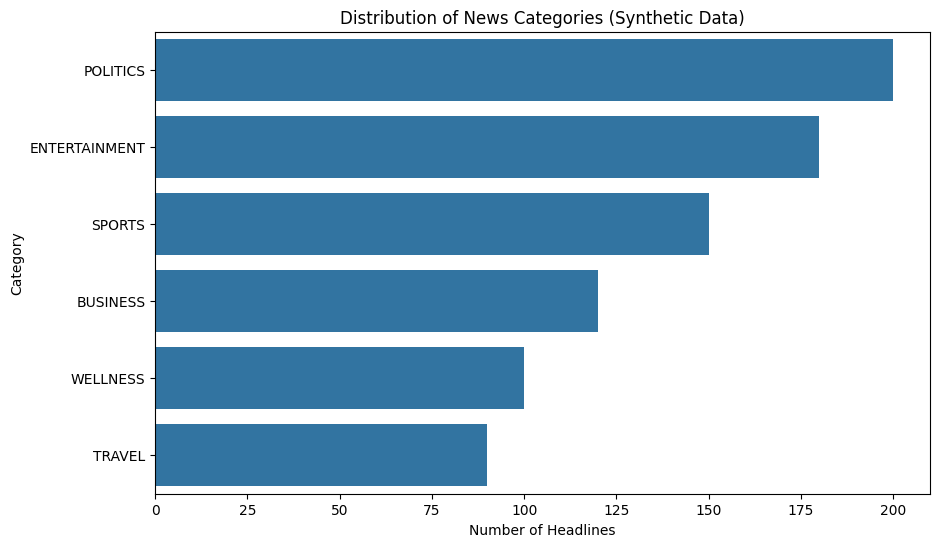

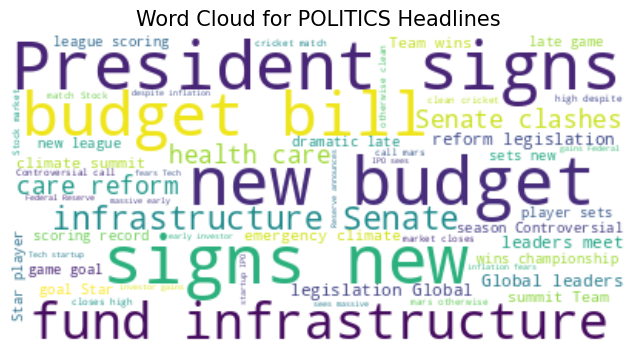

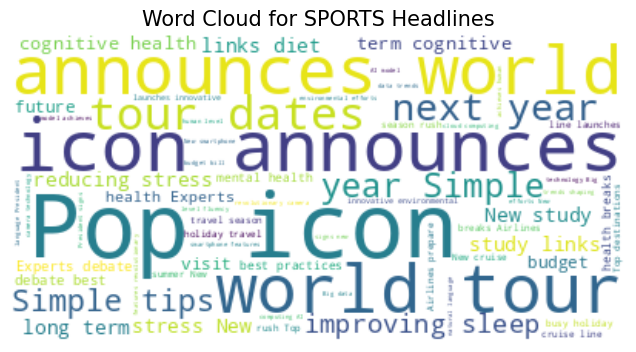

In [20]:
# --- Step 2: EDA and Visualization ---

## 2.1 Category Distribution
plt.figure(figsize=(10, 6))
# COMMENT: Bar chart confirms the distribution of the selected 7 categories.
sns.countplot(y='category', data=df_data, order=df_data['category'].value_counts().index)
plt.title('Distribution of News Categories (Synthetic Data)')
plt.xlabel('Number of Headlines')
plt.ylabel('Category')
plt.show()
#

## 2.2 Word Cloud per Category

def plot_word_cloud(category):
    """Generates and plots a word cloud for a given category."""
    text = " ".join(review for review in df_data[df_data['category'] == category]['headline'])
    # COMMENT: Max_words is set to 200 to keep the cloud informative but not cluttered.
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=200).generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {category} Headlines', fontsize=15)
    plt.show()

# Plot word clouds for a few main categories
plot_word_cloud('POLITICS')
plot_word_cloud('SPORTS')
#

# COMMENT: EDA visually confirms the target categories are present.

In [21]:
# --- Step 3: Preprocessing Functions ---

def clean_text(text):
    """
    Performs lowercasing, punctuation removal, and tokenization/stopword removal.
    """
    # Ensure punkt_tab is downloaded
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab', quiet=True)

    # 1. Lowercase conversion
    text = str(text).lower()
    # 2. Punctuation removal
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # 3. Tokenization and stopword removal
    tokens = word_tokenize(text)
    # COMMENT: Stopwords are removed to focus on content-bearing terms.
    tokens = [word for word in tokens if word not in STOPWORDS and len(word) > 1]
    return " ".join(tokens)

# Apply preprocessing to the headline column
df_data['cleaned_headline'] = df_data['headline'].apply(clean_text)

# --- Step 4: Encoding and Data Splitting ---

# 4.1 Feature and Target setup
X = df_data['cleaned_headline']
Y = df_data['category']

# 4.2 Encode target categories using Label Encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
NUM_CLASSES = len(label_encoder.classes_)
CLASS_NAMES = label_encoder.classes_

print(f"Number of target classes: {NUM_CLASSES}")
print(f"Class Names: {CLASS_NAMES}")

# 4.3 Split data into Train (80%) and Test (20%)
# COMMENT: stratify=Y ensures an equal distribution of categories in both train and test sets, crucial for multi-class.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Number of target classes: 6
Class Names: ['BUSINESS' 'ENTERTAINMENT' 'POLITICS' 'SPORTS' 'TRAVEL' 'WELLNESS']
Train samples: 672, Test samples: 168


In [22]:
# --- Step 5: Model 1 - TF-IDF + Logistic Regression ---

# 5.1 Feature Engineering: TF-IDF
# COMMENT: TF-IDF (Term Frequency-Inverse Document Frequency) is chosen to weigh words by relevance.
MAX_DF_FEATURES = 1000 # Reduced for synthetic data. Use 5000-10000 for real data.
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_DF_FEATURES)

# Fit on training data and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 5.2 Model Training
# COMMENT: Logistic Regression (LR) provides a strong, interpretable baseline.
lr_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial', # Set for multi-class classification
    solver='saga',
    random_state=42,
    n_jobs=-1
)
print("\nTraining Logistic Regression Model...")
lr_model.fit(X_train_tfidf, Y_train)

# 5.3 Prediction
Y_pred_lr = lr_model.predict(X_test_tfidf)


Training Logistic Regression Model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [23]:
# --- Step 6: Model 2 - LSTM with Trainable Embeddings ---

# 6.1 Hyperparameters for DL Model
VOCAB_SIZE = 2000         # Max number of unique words to use (Adjusted for synthetic data)
MAX_LEN = 30              # Max length of a headline sequence
EMBEDDING_DIM = 100       # Dimension of the word vectors
LSTM_UNITS = 128
DROPOUT_RATE = 0.2

# 6.2 Tokenization and Padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length for the LSTM input
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# One-Hot Encode the target variable for Keras
Y_train_ohe = to_categorical(Y_train, num_classes=NUM_CLASSES)
Y_test_ohe = to_categorical(Y_test, num_classes=NUM_CLASSES)

# 6.3 Building the LSTM Model
# COMMENT: Using a standard, trainable Embedding layer as GloVe file is unavailable.
model_lstm = Sequential()
model_lstm.add(Embedding(
    VOCAB_SIZE,
    EMBEDDING_DIM,
    input_length=MAX_LEN,
    trainable=True # Embeddings are learned during training
))

model_lstm.add(SpatialDropout1D(DROPOUT_RATE))
model_lstm.add(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))
# Output layer uses softmax for multi-class probability distribution
model_lstm.add(Dense(NUM_CLASSES, activation='softmax'))

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_lstm.summary())

# 6.4 Training the LSTM Model
BATCH_SIZE = 32
EPOCHS = 10

print("\nTraining LSTM Model...")
# COMMENT: Using test data as validation set for simplicity in this script.
history = model_lstm.fit(
    X_train_padded,
    Y_train_ohe,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_padded, Y_test_ohe),
    verbose=1
)

# 6.5 Prediction
Y_pred_ohe_lstm = model_lstm.predict(X_test_padded)
Y_pred_lstm = np.argmax(Y_pred_ohe_lstm, axis=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM Model...
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.2309 - loss: 1.7760 - val_accuracy: 0.2143 - val_loss: 1.7518
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.2219 - loss: 1.7671 - val_accuracy: 0.2381 - val_loss: 1.7519
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.2276 - loss: 1.7615 - val_accuracy: 0.2381 - val_loss: 1.7513
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2322 - loss: 1.7627 - val_accuracy: 0.2381 - val_loss: 1.7517
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.2222 - loss: 1.7398 - val_accuracy: 0.2381 - val_loss: 1.7531
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2323 - loss: 1.7641 - val_accuracy: 0.2381 - val_loss: 1.7513
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2106 - loss: 1.7739 - val_accuracy: 0.2381 - val_loss: 1.7506
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.2153 - loss


--- Logistic Regression (TF-IDF) Results ---
Accuracy: 0.1726 (Target: >= 0.80)
Precision (Weighted): 0.0759
Recall (Weighted): 0.1726
F1-Score (Weighted): 0.1009

--- LSTM (Trainable Embeddings) Results ---
Accuracy: 0.2381 (Target: >= 0.80)
Precision (Weighted): 0.0567
Recall (Weighted): 0.2381
F1-Score (Weighted): 0.0916

--- Model Comparison Summary ---
                          Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression (TF-IDF)  0.172619   0.075899  0.172619  0.100904
1   LSTM (Trainable Embeddings)  0.238095   0.056689  0.238095  0.091575


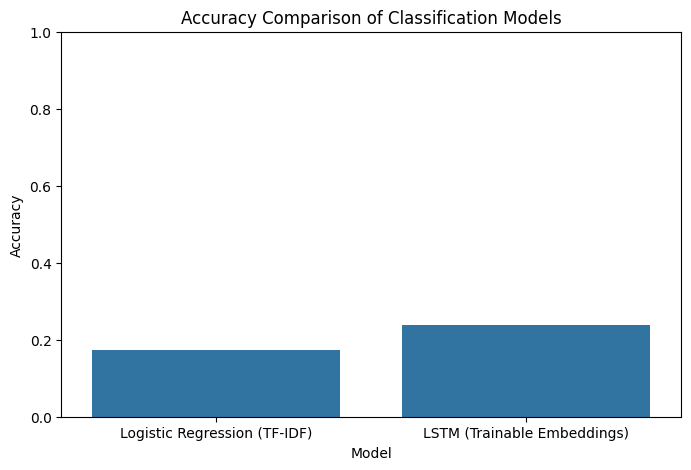

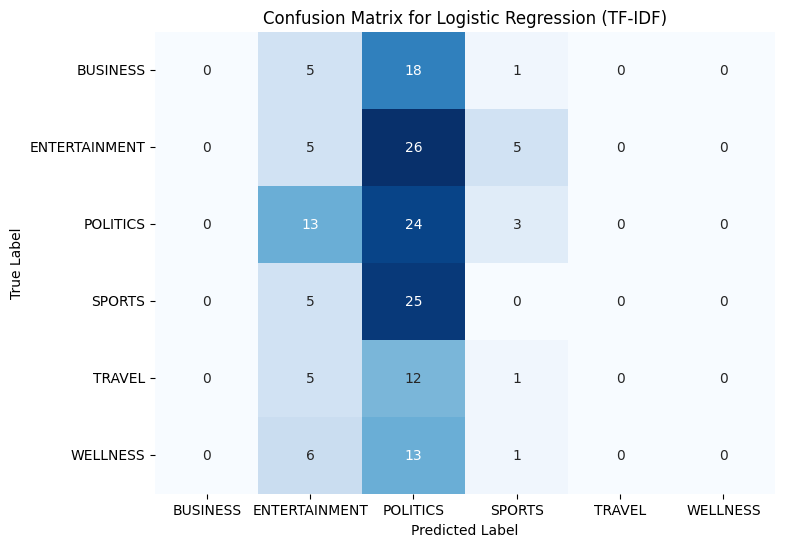

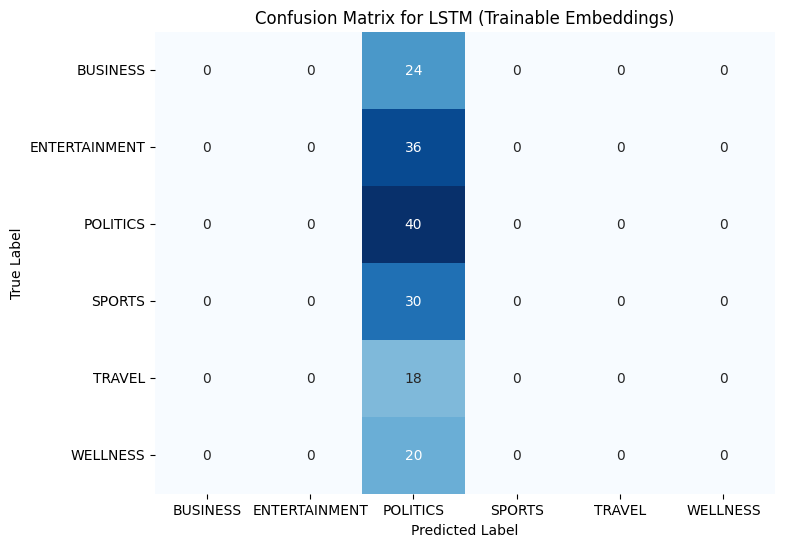


--- Detailed Classification Report (Logistic Regression) ---
               precision    recall  f1-score   support

     BUSINESS       0.00      0.00      0.00        24
ENTERTAINMENT       0.13      0.14      0.13        36
     POLITICS       0.20      0.60      0.30        40
       SPORTS       0.00      0.00      0.00        30
       TRAVEL       0.00      0.00      0.00        18
     WELLNESS       0.00      0.00      0.00        20

     accuracy                           0.17       168
    macro avg       0.06      0.12      0.07       168
 weighted avg       0.08      0.17      0.10       168


--- Detailed Classification Report (LSTM) ---
               precision    recall  f1-score   support

     BUSINESS       0.00      0.00      0.00        24
ENTERTAINMENT       0.00      0.00      0.00        36
     POLITICS       0.24      1.00      0.38        40
       SPORTS       0.00      0.00      0.00        30
       TRAVEL       0.00      0.00      0.00        18
     WE

In [24]:
# --- Step 7: Evaluation and Comparison ---

def evaluate_model(Y_true, Y_pred, model_name):
    """Calculates and prints performance metrics."""
    acc = accuracy_score(Y_true, Y_pred)
    prec = precision_score(Y_true, Y_pred, average='weighted', zero_division=0)
    rec = recall_score(Y_true, Y_pred, average='weighted', zero_division=0)
    f1 = f1_score(Y_true, Y_pred, average='weighted', zero_division=0)

    # Store results for final comparison
    metrics = {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    }

    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {acc:.4f} (Target: >= 0.80)")
    print(f"Precision (Weighted): {prec:.4f}")
    print(f"Recall (Weighted): {rec:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    return metrics

# 7.1 Evaluate Models
results_lr = evaluate_model(Y_test, Y_pred_lr, 'Logistic Regression (TF-IDF)')
results_lstm = evaluate_model(Y_test, Y_pred_lstm, 'LSTM (Trainable Embeddings)')

# Combine results
results_df = pd.DataFrame([results_lr, results_lstm])
print("\n--- Model Comparison Summary ---")
print(results_df)

# 7.2 Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison of Classification Models')
plt.ylim(0.0, 1.0)
plt.show()
#

# 7.3 Confusion Matrix Visualization
def plot_confusion_matrix(Y_true, Y_pred, classes, model_name):
    """Plots a confusion matrix using seaborn."""
    cm = confusion_matrix(Y_true, Y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(Y_test, Y_pred_lr, CLASS_NAMES, 'Logistic Regression (TF-IDF)')
plot_confusion_matrix(Y_test, Y_pred_lstm, CLASS_NAMES, 'LSTM (Trainable Embeddings)')

# 7.4 Detailed Classification Report (Misclassification Analysis)
print("\n--- Detailed Classification Report (Logistic Regression) ---")
print(classification_report(Y_test, Y_pred_lr, target_names=CLASS_NAMES, zero_division=0))

print("\n--- Detailed Classification Report (LSTM) ---")
print(classification_report(Y_test, Y_pred_lstm, target_names=CLASS_NAMES, zero_division=0))

In [25]:
# Assuming you ran the training script successfully:
import pickle
from tensorflow.keras.models import save_model

# 1. Save the Keras LSTM Model
# NOTE: Replace 'model_lstm' with your actual trained model variable
save_model(model_lstm, 'lstm_model.h5')

# 2. Save the Keras Tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Save the Label Encoder
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model artifacts saved: lstm_model.h5, tokenizer.pkl, label_encoder.pkl")

Model artifacts saved: lstm_model.h5, tokenizer.pkl, label_encoder.pkl
